In [ ]:
install.packages('mixtools')
install.packages('concordance')

In [119]:
library(readxl)
library(purrr)
library(dplyr)
library(tidyr)
library(haven)
library(mixtools)
library(concordance)
library(ggplot2)
source('./explore.R')

In [4]:
dat.97 <- rbind(read_excel('./years/oes97in3/nat2d_sic_1997_dl.xls', skip = 32),
                read_excel('./years/oes97in3/nat3d_sic_1997_dl.xls', skip = 32)) %>%
    rename_all(toupper)

In [6]:
dat.03 <- rbind(read_excel('./years/oesm03in4/nat4d_may2003_dl.xls'), read_excel('./years/oesm03in4/nat3d_may2003_dl.xls'), read_excel('./years/oesm03in4/nat5d_may2003_dl.xls'))

In [5]:
dat.16 <- rbind(read_excel('./years/oesm16in4/oesm16in4/nat3d_M2016_dl.xlsx'), read_excel('./years/oesm16in4/oesm16in4/nat4d_M2016_dl.xlsx'), read_excel('./years/oesm16in4/oesm16in4/nat5d_6d_M2016_dl.xlsx'))

In [82]:
codes <- dat.03 %>% group_by(NAICS) %>% count() %>% arrange(n) %>% tail(1000) %>% pull(NAICS)

In [ ]:
extract.wb <- function(path) {
    v <- read.csv(path, skip=3) %>% filter(Country.Name == 'United States') %>% select(5:61) %>% as.numeric
    data.frame(year = 1960:2016, val = v)
}

inflation <- extract.wb('GDP/deflator.csv') %>% mutate(price.deflator = val)
gdp <- extract.wb('GDP/gdp.csv') %>% mutate(gdp.deflator = val/last(val) * 100)
deflators <- inflation %>% mutate(gdp.deflator = gdp$gdp.deflator) %>% select(-val)
gdp.trend <- coef(lm(log(val) ~ year, data = gdp %>% filter(year > 2003)))[[2]]
gdp.trend

In [83]:
lookup <- dat.16 %>% 
    select(NAICS, NAICS_TITLE, TOT_EMP) %>% 
    mutate(TOT_EMP = as.numeric(TOT_EMP)) %>% 
    filter(!is.na(TOT_EMP)) %>%
    group_by(NAICS) %>% 
    summarize(employed = sum(TOT_EMP, drop.na = TRUE), NAICS_TITLE = first(NAICS_TITLE))

Warning message in evalq(as.numeric(TOT_EMP), <environment>):
“NAs introduced by coercion”

In [ ]:
mixes.16 <- get.mixes(dat.16)
mixes.03 <- get.mixes(dat.03)

In [86]:
d <- adjust(mixes.16, deflators, 2016) %>% mutate(year = 2016) %>% rbind(adjust(mixes.03, deflators, 2003) %>% mutate(year = 2003))
fin <- d %>% group_by(NAICS) %>% nest() %>% mutate(d = map(data, get.diffs)) %>% select(-data) %>% unnest()

In [95]:
joined <- fin %>% left_join(lookup, by='NAICS')
spreads <- fin %>% 
    mutate(NAICS_TITLE = joined$NAICS_TITLE, employed = joined$employed) %>% 
    arrange(spread) %>% 
    filter(employed > 50000) %>%
    mutate(lows = lows - gdp.trend*(2016-2003), highs = highs - gdp.trend*(2016-2003))

In [96]:
markups <- read_stata('./markups/markups.dta') %>% mutate(naics4 = as.character(ind4d * 100))
markup.wide <- markups %>% select(naics4, year, agg_markup) %>% spread(year, agg_markup) %>% mutate(growth = `2014` - `2003`)

In [136]:
spreads %>% inner_join(markup.wide, by = c(NAICS = "naics4")) %>% lm(spread ~ growth, data = .) %>% summary()


Call:
lm(formula = spread ~ growth, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.58866 -0.03957  0.00021  0.04105  0.52842 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.037842   0.007558   5.007 1.16e-06 ***
growth      0.026439   0.016237   1.628    0.105    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1072 on 212 degrees of freedom
  (27 observations deleted due to missingness)
Multiple R-squared:  0.01235,	Adjusted R-squared:  0.007693 
F-statistic: 2.651 on 1 and 212 DF,  p-value: 0.105


In [137]:
spreads %>% inner_join(markup.wide, by = (c('NAICS' = 'naics4'))) %>% lm(spread ~ `2003`, data = .) %>% summary()


Call:
lm(formula = spread ~ `2003`, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.59115 -0.04198 -0.00043  0.04474  0.52037 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.02608    0.02209   1.180    0.239
`2003`       0.01239    0.01542   0.803    0.423

Residual standard error: 0.1063 on 228 degrees of freedom
  (11 observations deleted due to missingness)
Multiple R-squared:  0.002823,	Adjusted R-squared:  -0.001551 
F-statistic: 0.6454 on 1 and 228 DF,  p-value: 0.4226


Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

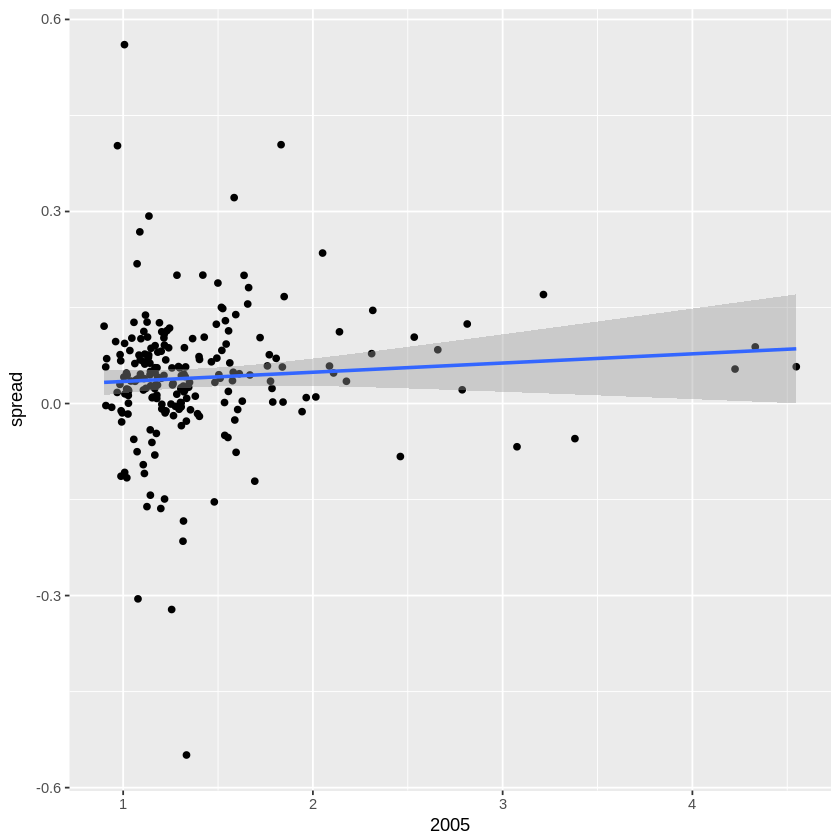

In [132]:
spreads %>% 
    inner_join(markup.wide, by = c('NAICS' = 'naics4')) %>% 
#     select(`2003`, `2014`, NAICS, spread, growth, NAICS_TITLE) %>% 
    mutate(`2003` = scale(`2003`), `2014` = scale(`2014`)) %>% 
    mutate(scaled_growth = `2014` - `2003`) %>%
    filter(!is.na(scaled_growth)) %>%
    ggplot(aes(x = `2005`, y = spread)) + geom_point() + geom_smooth(method = 'lm')

In [133]:
prep.bls(dat.16) %>% summarize(var = var(log(A_MEDIAN))) %>% inner_join(markup.wide, by = c(NAICS = "naics4")) %>% lm(var ~ growth, data = .) %>% summary()

Warning message in evalq(as.numeric(A_MEDIAN), <environment>):
“NAs introduced by coercion”


Call:
lm(formula = var ~ growth, data = .)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.101115 -0.027134 -0.000748  0.025858  0.103637 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.194518   0.002771  70.208   <2e-16 ***
growth      0.015168   0.004688   3.236   0.0014 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03989 on 217 degrees of freedom
  (28 observations deleted due to missingness)
Multiple R-squared:  0.04603,	Adjusted R-squared:  0.04163 
F-statistic: 10.47 on 1 and 217 DF,  p-value: 0.001403


Warning message in evalq(as.numeric(A_MEDIAN), <environment>):
“NAs introduced by coercion”Warning message:
“Removed 28 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 28 rows containing missing values (geom_point).”

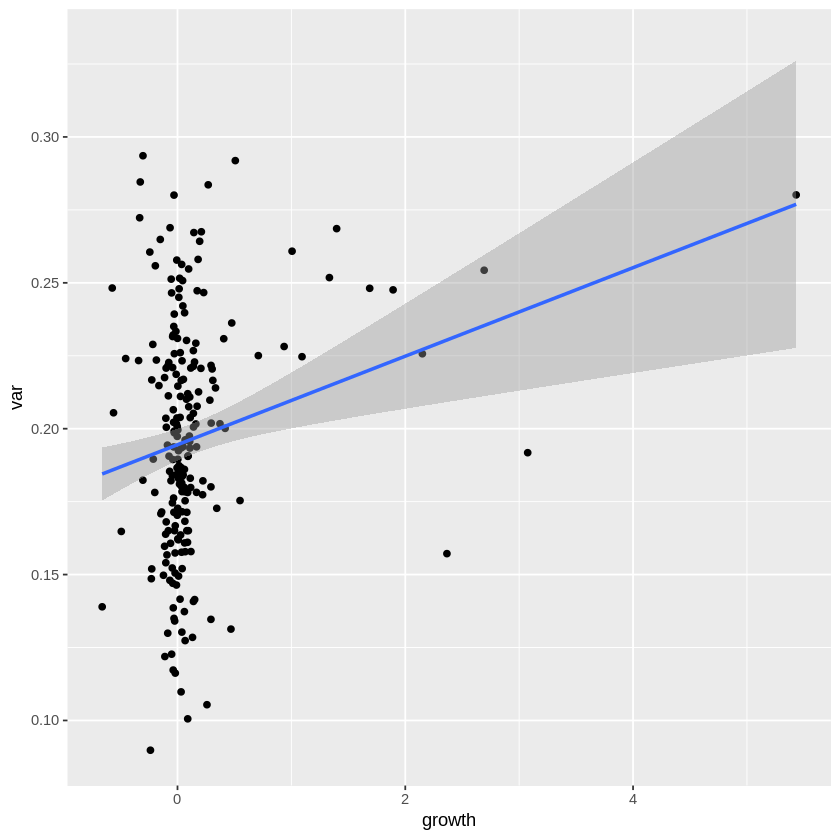

In [135]:
prep.bls(dat.16) %>% summarize(var = var(log(A_MEDIAN))) %>% inner_join(markup.wide, by = c(NAICS = "naics4")) %>% ggplot(aes(x = growth, y = var)) + geom_point() + geom_smooth(method='lm')